In [1]:
import scipy.io as scio
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import random
from tqdm import tqdm
import zipfile
import sys
rootpath = "/home/wangyf/Documents/codes/TrajectoryDataMining_codes"
sys.path.append(rootpath)

filepath4 = rootpath + "/datasets/Data2/cross/test.mat"
filepath5 = rootpath + "/datasets/Data2/cross/train.mat"

data = scio.loadmat(filepath4)
ablabels = np.ravel(data['abnormal_offline'])
tracks = data['tracks']
abnormal_idx = np.where(ablabels == 1)[0]
normal_idx = np.where(ablabels == 0)[0]

labels = data['labels'][0]
normal_labels = labels[:-200]
labelDic = {}
for i in range(1, 20):
    labelDic[i] = np.where(labels == i)[0]

traindata = []
allpoints = []
for i in normal_idx:
    traindata.append(tracks[i][0].T.tolist())
    allpoints += tracks[i][0].T.tolist()


In [2]:
def proc_cross(tracks):
    alltracks = []
    for i in range(tracks.shape[0]):
        per_track = []
        for j in range(tracks[i][0].shape[1]):
            per_track.append(tracks[i][0][:,j].tolist())
        alltracks.append(per_track)
    return alltracks

In [3]:
data1 = scio.loadmat(filepath4)
data2 = scio.loadmat(filepath5)
classlabels = data1['labels']
tjlist1 = proc_cross(data1['tracks'])
tjlist2 = proc_cross(data2['tracks_train'])
cross = tjlist1 + tjlist2

In [5]:
from codes.Algorithm1.iNNE_IK import iNN_IK
# map1
def idkmap(list_of_distributions, psi1, t1):
    D_idx = [0]  # index of each distributions
    alldata = []
    n = len(list_of_distributions)
    for i in range(1, n + 1):
        D_idx.append(D_idx[i - 1] + len(list_of_distributions[i - 1]))
        alldata += list_of_distributions[i - 1]
    alldata = np.array(alldata)
    inne_ik = iNN_IK(psi1, t1)
    all_ikmap = inne_ik.fit_transform(alldata).toarray()
    idkmap = []
    for i in range(n):
        idkmap.append(np.sum(all_ikmap[D_idx[i]:D_idx[i + 1]], axis=0) / (D_idx[i + 1] - D_idx[i]))
    idk_map1 = np.array(idkmap)
    idk_score1 = np.dot(idk_map1, np.mean(idk_map1, axis=0))
    return all_ikmap, idk_map1, D_idx

# # map2
# inne_ik = iNN_IK(psi2, t2)
# idk_map2 = inne_ik.fit_transform(idk_map1).toarray()
# idkm2_mean = np.average(idk_map2, axis=0) / t1
# idk_score = np.dot(idk_map2, idkm2_mean.T)

In [6]:
def getCluster(cluster_i_idx, all_ikmap, D_idx):
    # cluster_i_idx = labelDic[id]
    cluster_i_allidkmap = []
    cluster_i_idkmap = []
    cluster_i_D_idx = [0]
    for i in cluster_i_idx:
        cluster_i_allidkmap.append(all_ikmap[D_idx[i]:D_idx[i+1]])
        cluster_i_idkmap.append(np.average(all_ikmap[D_idx[i]:D_idx[i+1]], axis=0))
        cluster_i_D_idx.append(cluster_i_D_idx[-1] + (D_idx[i+1] - D_idx[i]))
    cluster_i_allidkmap = np.concatenate(cluster_i_allidkmap, axis=0)
    cluster_i_idkmap = np.vstack(cluster_i_idkmap)
    return cluster_i_D_idx, cluster_i_allidkmap, cluster_i_idkmap


In [7]:
def extractPattern(dataset, labelDic, cluster_i, cluster_j, all_ikmap, D_idx, th=0.05):
    cluster_i_idx = labelDic[cluster_i]
    cluster_j_idx = labelDic[cluster_j]
    R = []
    R_idk = []
    cluster_i_D_idx, cluster_i_allidkmap, cluster_i_idkmap = getCluster(cluster_i_idx, all_ikmap, D_idx)
    cluster_j_D_idx, cluster_j_allidkmap, cluster_j_idkmap = getCluster(cluster_j_idx, all_ikmap, D_idx)
    c_i = np.average(cluster_i_idkmap, axis=0)
    c_j = np.average(cluster_j_idkmap, axis=0)
    if(np.dot(c_i, c_j) == 0):
        return R, R_idk
    score_jj = np.dot(cluster_j_idkmap, np.average(cluster_j_idkmap, axis=0))
    cj_r = np.argmax(score_jj)
    score_ci_cj_r = np.dot(cluster_j_allidkmap[cluster_j_D_idx[cj_r]:cluster_j_D_idx[cj_r+1]], c_i)
    pattern = np.where(score_ci_cj_r > th)[0]
    if(pattern.shape[0] < 4):
        return R, R_idk
    cols = ['orange', 'blue', 'green', 'red']
    # print(tracks[labelDic[cluster_j][cj_r]][0].T[pattern])
    tj = np.array(dataset[cluster_j_idx[cj_r]])
    R.append(tj[pattern])
    R_idk.append(cluster_j_allidkmap[cluster_j_D_idx[cj_r]:cluster_j_D_idx[cj_r+1]][pattern])
    # plt.figure(figsize=(12, 4))
    # plt.subplot(121)
    # for j in cluster_i_idx:
    #     plt.plot(tracks[j][0][0,:], tracks[j][0][1,:], c=cols[0], alpha=0.2)
    # plt.plot(tracks[j][0][0,:], tracks[j][0][1,:], c=cols[0], alpha=0.2, label=cluster_i)
    # for j in cluster_j_idx:
    #     plt.plot(tracks[j][0][0,:], tracks[j][0][1,:], c=cols[1], alpha=0.2)
    # plt.plot(tracks[j][0][0,:], tracks[j][0][1,:], c=cols[1], alpha=0.2, label=cluster_j)
    # # plt.plot(tracks[labelDic[7][0]][0][0,:], tracks[labelDic[7][0]][0][1,:], c='black')
    # plt.legend()
    # plt.plot(tracks[cluster_j_idx[cj_r]][0][0,pattern], tracks[cluster_j_idx[cj_r]][0][1,pattern], '-o', c='yellow')
    # plt.subplot(122)
    # plt.ylim(-0.1, 1)
    # plt.plot(score_ci_cj_r, '-o', c='blue')
    # plt.plot(pattern, score_ci_cj_r[pattern], '-o', c='red')
    # plt.show()

    return R, R_idk


In [8]:
# how to filter patterns which are similar?
from hausdorff import hausdorff_distance
from similaritymeasures import frechet_dist
from fastdtw import fastdtw
def filter_patterns(R, th=70, th2=0):
    R.sort(key=lambda r : r.shape[0], reverse=False)
    sim = []
    def exist(FreqPatterns_idx, i):
        for j in FreqPatterns_idx:
            # s = np.dot(np.average(R_idk[i], axis=0), np.average(R_idk[j], axis=0))
            # s = hausdorff_distance(R[i], R[j])
            s, _ = fastdtw(R[i], R[j]) 
            s = s / R[i].shape[0] / R[j].shape[0]
            # s = frechet_dist(R[i], R[j])
            sim.append(s)
            if s < th:
                return True
        return False

    FreqPatterns_idx = []
    FreqPatterns = []
    for i in range(len(R)):
        print(len(R[i]))
        if not exist(FreqPatterns_idx, i):
            if(len(R[i]) > th2):
                FreqPatterns_idx.append(i)
                FreqPatterns.append(R[i])
    # print(pd.Series(sim).value_counts())
    return FreqPatterns, FreqPatterns_idx

In [9]:
def extractPattern_v2(traindata, labelDic, cluster_i, all_ikmap, D_idx, th):
    cluster_i_idx = labelDic[cluster_i]
    R = []
    R_idk = []
    cluster_i_D_idx, cluster_i_allidkmap, cluster_i_idkmap = getCluster(cluster_i_idx, all_ikmap, D_idx)
    c_i = np.average(cluster_i_idkmap, axis=0)
    c_d = np.average(all_ikmap, axis=0)
    if(np.dot(c_i, c_d) == 0):
        return R, R_idk
    score_ii = np.dot(cluster_i_idkmap, np.average(cluster_i_idkmap, axis=0))
    ci_r = np.argmax(score_ii)
    score_ci_cd_r = np.dot(cluster_i_allidkmap[cluster_i_D_idx[ci_r]:cluster_i_D_idx[ci_r+1]], c_d)
    print(score_ci_cd_r)
    # threshold
    pattern = np.where(score_ci_cd_r > th)[0]
    pattern_filter = []
    
    if(len(pattern) == 0):
        return R, R_idk

    sub_p = [pattern[0]]
    for i in range(1, len(pattern)):
        if(pattern[i] - pattern[i-1] > 1):
            if len(sub_p) >= 4: 
                pattern_filter.append(sub_p)
                tj = np.array(traindata[cluster_i_idx[ci_r]])
                R.append(tj[sub_p])
                R_idk.append(cluster_i_allidkmap[cluster_i_D_idx[ci_r]:cluster_i_D_idx[ci_r+1]][sub_p])
            sub_p = [pattern[i]]
        else:
            sub_p.append(pattern[i])
    if len(sub_p) >= 4: 
        pattern_filter.append(sub_p)
        tj = np.array(traindata[cluster_i_idx[ci_r]])
        R.append(tj[sub_p])
        R_idk.append(cluster_i_allidkmap[cluster_i_D_idx[ci_r]:cluster_i_D_idx[ci_r+1]][sub_p])
        
    # if(pattern.shape[0] < 4):
    #     return R, R_idk
    # cols = ['orange', 'blue', 'green', 'red']
    # # print(tracks[labelDic[cluster_j][cj_r]][0].T[pattern])
    # R.append(tracks[cluster_i_idx[ci_r]][0].T[pattern])
    # R_idk.append(cluster_i_allidkmap[cluster_i_D_idx[ci_r]:cluster_i_D_idx[ci_r+1]][pattern])
    return R, R_idk

In [10]:
# all_ikmap, idk_map1, D_idx = idkmap(traindata, psi1=1024, t1=100)
# R = []
# R_idk = []
# for i in range(1, 19):
#     for j in range(i+1, 20):
#         r1, r2 = extractPattern(labelDic, i, j, all_ikmap, D_idx)
#         R.extend(r1)
#         R_idk.extend(r2)

In [11]:
# import matplotlib.pyplot as plt
# allpoints = np.array(allpoints)
# FreqPatterns, FreqPatterns_idx = filter_patterns_v2(R, R_idk, th=0)
# plt.figure(figsize=(12, 5))
# plt.subplot(121)
# plt.scatter(allpoints[:,0], allpoints[:,1], s=0.1, alpha=0.2)
# for t in R:
#     plt.plot(t[:,0], t[:,1], '-o', c='yellow')

# plt.subplot(122)
# plt.scatter(allpoints[:,0], allpoints[:,1], s=0.1, alpha=0.2)
# for t in FreqPatterns:
#     plt.plot(t[:,0], t[:,1], '-o', c='yellow')
# plt.show()

In [12]:
# FreqPatterns = np.load("ground_res.npy", allow_pickle=True)
# ax = plt.axes()
# ax.set_axis_off()
# plt.scatter(allpoints[:,0], allpoints[:,1], s=0.1, alpha=0.2)
# for t in FreqPatterns:
#     plt.plot(t[:,0], t[:,1], '-o', lw=2, ms=4, c='orange')
# plt.show()

# Example on Cross

In [ ]:
all_ikmap, idk_map1, D_idx = idkmap(traindata, psi1=1024, t1=100)
R = []
R_idk = []
for i in range(1, 20):
    r1, r2 = extractPattern_v2(traindata, labelDic, i, all_ikmap, D_idx, th=0.07)
    R.extend(r1)
    R_idk.extend(r2)

In [ ]:
import matplotlib.pyplot as plt
allpoints = np.array(allpoints)
FreqPatterns, FreqPatterns_idx = filter_patterns(R, th=30)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(allpoints[:,0], allpoints[:,1], s=0.1, alpha=0.2)
for t in R:
    plt.plot(t[:,0], t[:,1], '-o', c='yellow')

plt.subplot(122)
plt.scatter(allpoints[:,0], allpoints[:,1], s=0.1, alpha=0.2)
for t in FreqPatterns:
    plt.plot(t[:,0], t[:,1], '-o', c='yellow')
plt.show()

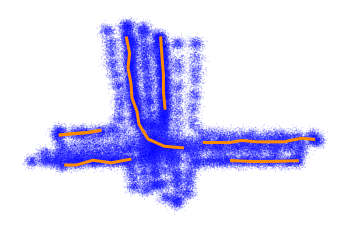

In [111]:
FreqPatterns = np.load("mv2_res1.npy", allow_pickle=True)
ax = plt.axes()
ax.set_axis_off()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
allpoints = np.array(allpoints)
plt.scatter(allpoints[:,0], allpoints[:,1], s=0.1, c='blue', alpha=0.2)
plt.scatter(allpoints[0,0], allpoints[0,1], s=3, c='blue', label='Points of Trajectories')
for t in FreqPatterns:
    plt.plot(t[:,0], t[:,1], lw=3, c='darkorange')
plt.plot(t[:,0], t[:,1], lw=3, c='darkorange', label='Frequent Pattern')

# plt.legend(fontsize=15)
plt.savefig("./cross_v2_1.png", dpi=1000)
plt.show()

# Example on Casia

In [27]:
import pandas as pd
import numpy as np
import sys
rootpath = "/home/wangyf/Documents/codes/TrajectoryDataMining_codes"
sys.path.append(rootpath)
import scipy.io as scio
alltraj = scio.loadmat(rootpath + "/datasets/Data2/CASIA_tjc.mat")
traindata_casia = []
allpoints_casia = []
for i in range(1500):
    n = len(alltraj['tjc'][i][0])
    cmd = []
    for j in range(n):
        cmd.append(alltraj['tjc'][i][0][j].tolist())
    traindata_casia.append(cmd)
    allpoints_casia.extend(cmd)
labels = np.ravel(alltraj['labels'])
labelDic_casia = {}
for i in range(1, 16):
    labelDic_casia[i] = np.where(labels == i)[0]


In [ ]:
all_ikmap, idk_map1, D_idx = idkmap(traindata_casia, psi1=16, t1=100)
R = []
R_idk = []
for i in range(1, 16):
   if(len(labelDic_casia[i]) < 50):
      continue
   r1, r2 = extractPattern_v2(traindata_casia, labelDic_casia, i, all_ikmap, D_idx, th=3)
   R.extend(r1)
   R_idk.extend(r2)

30
42
44
51
54
57
72
74
81
159
182
214
221
573


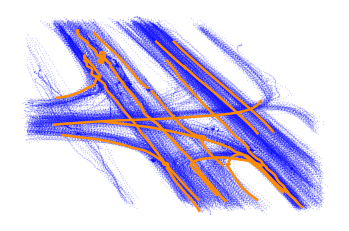

In [261]:
FreqPatterns, FreqPatterns_idx = filter_patterns(R, th=0.12, th2=10)
ax = plt.axes()
ax.set_axis_off()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.scatter(allpoints[:,0], allpoints[:,1], s=0.1, c='blue', alpha=0.2)
plt.scatter(allpoints[0,0], allpoints[0,1], s=3, c='blue', label='Points of Trajectories')
for t in FreqPatterns:
    plt.plot( t[:,0], t[:,1], '-', lw=2.5, c='darkorange')
plt.plot(t[:,0], t[:,1], '-', lw=2.5, c='darkorange', label='Frequent Pattern')
# plt.legend()
# plt.savefig("./casia_v2_0.png", dpi=1000)
plt.show()

30
42
44
51
54
57
72
74
81
159
182
214
221
573


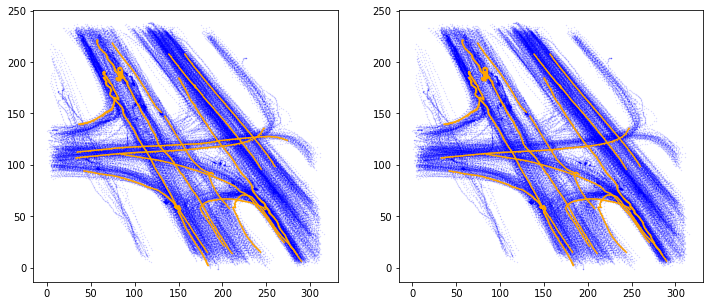

In [257]:
import matplotlib.pyplot as plt
allpoints = np.array(allpoints_casia)
FreqPatterns, FreqPatterns_idx = filter_patterns(R, th=0.12, th2=10)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(allpoints[:,0], allpoints[:,1], c='blue', s=0.1, alpha=0.2)
for t in R:
    plt.plot(t[:,0], t[:,1], '-o', ms=0.5, c='orange')
    # plt.scatter(t[:,0], t[:,1], s=0.5, c='orange')

plt.subplot(122)
plt.scatter(allpoints[:,0], allpoints[:,1], c='blue', s=0.1, alpha=0.2)
for t in FreqPatterns:
    plt.plot(t[:,0], t[:,1], '-o', ms=0.5, c='orange')
    # plt.scatter(t[:,0], t[:,1], s=0.5, c='orange')
plt.show()